###Objetivo Geral
###Treinar uma rede neural (MLP) para prever a sobrevivência de passageiros do Titanic, explorando problemas de viés e aplicando técnicas de balanceamento e enriquecimento de dados para mitigar injustiças no modelo.

##Contexto do Dataset
##Dataset Titanic (Kaggle/Datascience Dojo)
Informações de passageiros do Titanic: nome, sexo, idade, classe social (Pclass), tarifa (Fare), número de parentes a bordo (SibSp e Parch), local de embarque, entre outros.

Variável-alvo: Survived (1 = sobreviveu, 0 = não sobreviveu)

Por que há viés nesse dataset?
Classe social (Pclass): Passageiros da 1ª classe tiveram mais acesso aos botes salva-vidas.

Sexo: Mulheres tiveram prioridade no resgate (“mulheres e crianças primeiro”).

Isso causa viés de representatividade — o modelo pode aprender padrões sociais injustos (ex: associar “ser homem” ou “ser da 3ª classe” com menor chance de sobrevivência).

In [302]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
sns.set(style="whitegrid")

In [303]:
# Carrega o conjunto de dados Titanic diretamente de um repositório no GitHub
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Seleciona apenas as colunas 'Sex', 'Pclass' e 'Survived', e remove linhas com valores ausentes (NaN)
df = df[['Sex', 'Pclass', 'Survived']].dropna()

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Sexo'] = df['Sex'].map({0: 'Homem', 1: 'Mulher'})
df['Classe'] = df['Pclass'].astype(str)
df['Sobreviveu'] = df['Survived'].map({0: 'Não', 1: 'Sim'})

C:\Users\jmarq\AppData\Local\Temp\ipykernel_12016\3978351522.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='Set2')


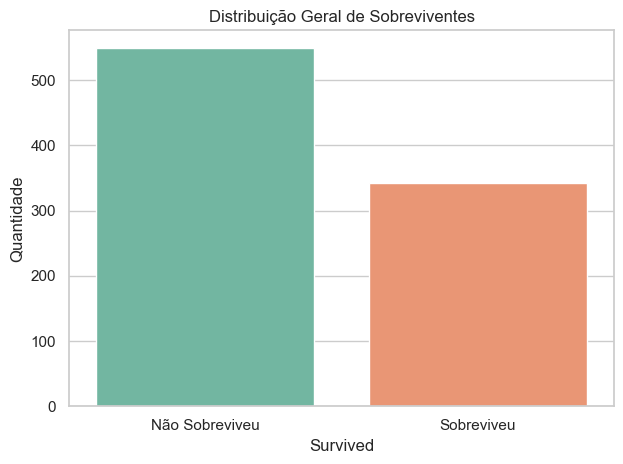

In [304]:
# plot da distribuição geral de sobreviventes
sns.countplot(x='Survived', data=df, palette='Set2')
plt.title("Distribuição Geral de Sobreviventes")
plt.xticks([0, 1], ['Não Sobreviveu', 'Sobreviveu'])
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

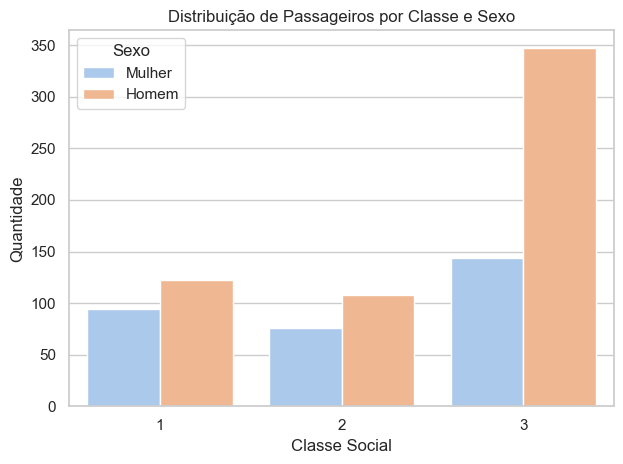

In [305]:
# plot da distribuição por classe e sexo
sns.countplot(x='Pclass', hue='Sexo', data=df, palette='pastel')
plt.title("Distribuição de Passageiros por Classe e Sexo")
plt.xlabel("Classe Social")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

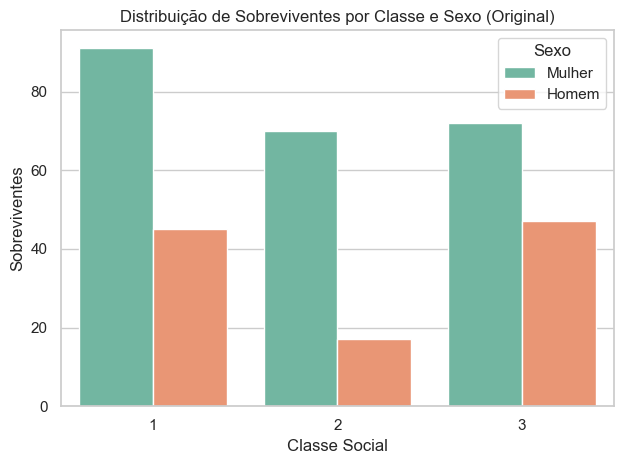

In [306]:
# Sobreviventes por classe e sexo
sobreviventes = df[df['Survived'] == 1]
sns.countplot(x='Pclass', hue='Sexo', data=sobreviventes, palette='Set2')
plt.title("Distribuição de Sobreviventes por Classe e Sexo (Original)")
plt.xlabel("Classe Social")
plt.ylabel("Sobreviventes")
plt.tight_layout()
plt.show()

C:\Users\jmarq\AppData\Local\Temp\ipykernel_12016\2932129216.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pclass', y='Survived', data=proporcao, palette='Blues_d')


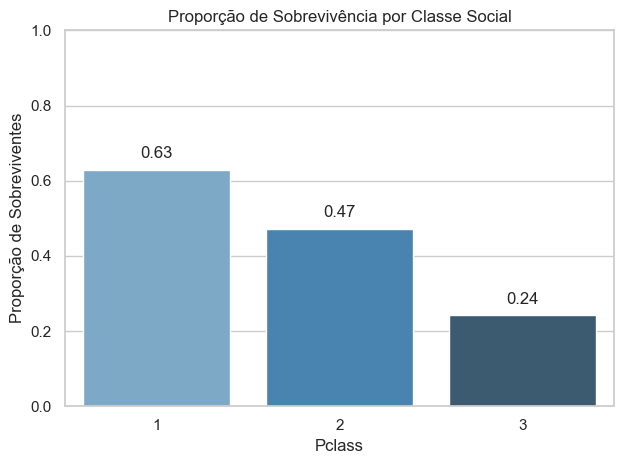

In [307]:
# Proporção de sobreviventes por classe
proporcao = df.groupby('Pclass')['Survived'].mean().reset_index()
sns.barplot(x='Pclass', y='Survived', data=proporcao, palette='Blues_d')
plt.title("Proporção de Sobrevivência por Classe Social")
plt.ylabel("Proporção de Sobreviventes")
plt.ylim(0, 1)
for i, val in enumerate(proporcao['Survived']):
    plt.text(i, val + 0.03, f"{val:.2f}", ha='center')
plt.tight_layout()
plt.show()

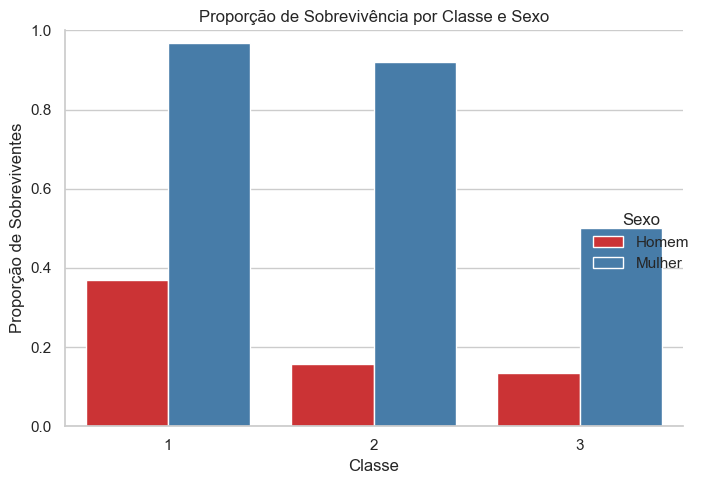

In [308]:
# Proporção de sobreviventes por classe e sexo
proporcao_sexo_classe = df.groupby(['Classe', 'Sexo'])['Survived'].mean().reset_index()
sns.catplot(data=proporcao_sexo_classe, x='Classe', y='Survived', hue='Sexo', kind='bar', palette='Set1', height=5, aspect=1.2)
plt.title("Proporção de Sobrevivência por Classe e Sexo")
plt.ylim(0, 1)
plt.ylabel("Proporção de Sobreviventes")
plt.tight_layout()
plt.show()

In [309]:
#Balanceamento do dataset

df_balanced = pd.DataFrame() 
# Itera sobre cada classe (1ª, 2ª, 3ª) e filtra
for pclass in df['Pclass'].unique(): 
    subset = df[df['Pclass'] == pclass]  # Filtra os dados da classe atual
    survived = subset[subset['Survived'] == 1]  # Filtra os passageiros que sobreviveram
    not_survived = subset[subset['Survived'] == 0]  # Filtra os passageiros que não sobreviveram
    min_len = min(len(survived), len(not_survived))  # Determina o menor grupo para balancear
    balanced_subset = pd.concat([  # Cria subconjunto balanceado por classe
        resample(survived, replace=False, n_samples=min_len, random_state=42),  # Amostra sobreviventes
        resample(not_survived, replace=False, n_samples=min_len, random_state=42)  # Amostra não sobreviventes
    ])
    df_balanced = pd.concat([df_balanced, balanced_subset])  # Adiciona ao DataFrame final

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Embaralha os dados e redefine os índices


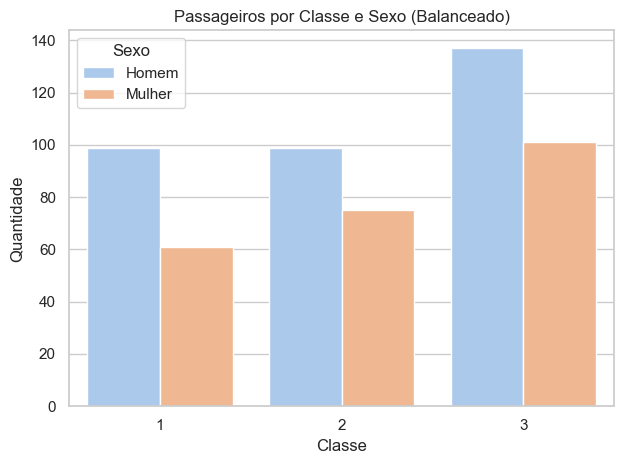

In [310]:
#Gráficos pós-balanceamento

# Passageiros por classe e sexo
sns.countplot(x='Pclass', hue='Sexo', data=df_balanced, palette='pastel')
plt.title("Passageiros por Classe e Sexo (Balanceado)")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()


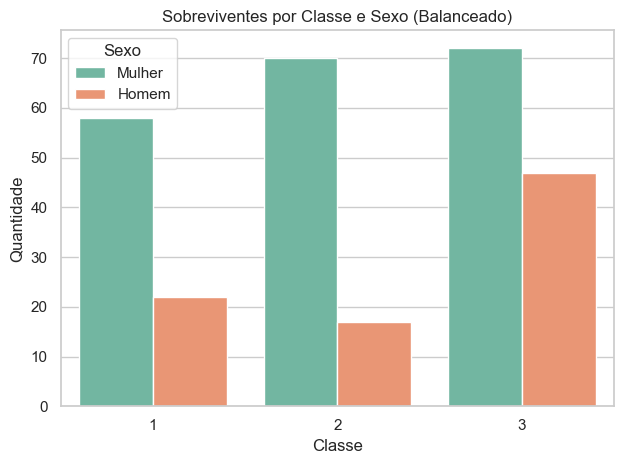

In [311]:
# Sobreviventes por classe e sexo (balanceado)
sobreviventes_bal = df_balanced[df_balanced['Survived'] == 1]
sns.countplot(x='Pclass', hue='Sexo', data=sobreviventes_bal, palette='Set2')
plt.title("Sobreviventes por Classe e Sexo (Balanceado)")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

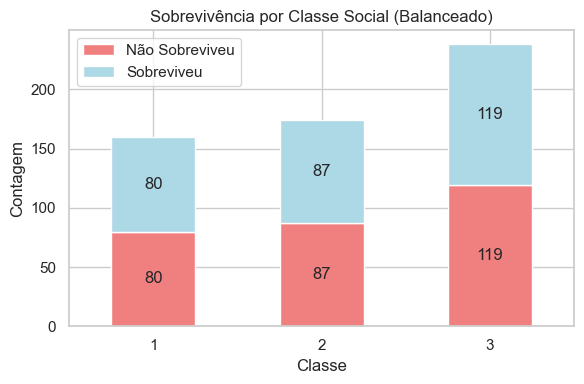

In [312]:
# Stacked bar – sobrevivência por classe
counts = df_balanced.groupby('Pclass')['Survived'].value_counts().unstack().fillna(0)
counts.columns = ['Não Sobreviveu', 'Sobreviveu']
ax = counts.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'], figsize=(6,4))
plt.title("Sobrevivência por Classe Social (Balanceado)")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.xticks(rotation=0)
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.tight_layout()
plt.show()


Balanceamento de Dados (Fairness Básica por Classe)
 O que foi feito:
Criado um novo DataFrame balanceado por classe social (Pclass).

Dentro de cada classe, igualou-se a quantidade de sobreviventes e não sobreviventes.

Por que isso é importante?
Sem balanceamento: o modelo aprende mais com grupos dominantes (maioria).

Com balanceamento: oferece igual peso a grupos desbalanceados -> evita que o modelo “ignore” minorias (como 3ª classe sobrevivente).

Pré-processamento: Divisão e Normalização
Divisão Treino/Teste
train_test_split separa 80% para treino e 20% para teste.

Garante que a performance seja medida em dados nunca vistos, simulando a aplicação real.

Normalização (StandardScaler)
Escala os dados para média 0 e desvio padrão 1.

Importante para redes neurais: evita que variáveis com maior escala (ex: Fare) dominem o cálculo dos gradientes -> acelera e melhora o treinamento.



In [313]:
# Separação e normalização

X = df_balanced[['Sex', 'Pclass']]  # Seleciona as variáveis independentes (features)
y = df_balanced['Survived']  # Seleciona a variável alvo (target)

X_train, X_test, y_train, y_test = train_test_split(  # Divide os dados em treino e teste
    X, y, test_size=0.2, random_state=42)  # 80% treino, 20% teste

scaler = StandardScaler()  # Inicializa o normalizador (padronização)

X_train_scaled = scaler.fit_transform(X_train)  # Ajusta e transforma os dados de treino
X_test_scaled = scaler.transform(X_test)  # Transforma os dados de teste com o mesmo ajuste


Treinamento da Rede Neural (MLPClassifier)
Arquitetura do Modelo
Modelo: MLPClassifier (Multi-Layer Perceptron)

Camadas ocultas: duas camadas com 16 e 8 neurônios, respectivamente

Função de ativação: ReLU (Rectified Linear Unit)

Fórmula: f(x) = max(0, x)

Introduz não-linearidade no modelo

Acelera o aprendizado e evita o problema do gradiente desvanecido (que afeta funções como sigmoid ou tanh)

Permite que o modelo aprenda relações complexas entre as variáveis

Otimizador:
Adam (Adaptive Moment Estimation)
Ajusta os pesos de forma adaptativa
É eficiente e robusto mesmo com muitos parâmetros

Época 0: Loss = 0.8033, Acurácia = 0.4267
Época 10: Loss = 0.7182, Acurácia = 0.5033
Época 20: Loss = 0.6675, Acurácia = 0.5952
Época 30: Loss = 0.6263, Acurácia = 0.6586
Época 40: Loss = 0.5880, Acurácia = 0.7812
Época 50: Loss = 0.5552, Acurácia = 0.7812
Época 60: Loss = 0.5279, Acurácia = 0.7812
Época 70: Loss = 0.5118, Acurácia = 0.7812
Época 80: Loss = 0.5052, Acurácia = 0.7812
Época 90: Loss = 0.5017, Acurácia = 0.7812
Época 100: Loss = 0.4992, Acurácia = 0.7812
Época 110: Loss = 0.4970, Acurácia = 0.7812
Época 120: Loss = 0.4954, Acurácia = 0.7812
Época 130: Loss = 0.4940, Acurácia = 0.7812
Época 140: Loss = 0.4931, Acurácia = 0.7812
Época 150: Loss = 0.4925, Acurácia = 0.7812
Época 160: Loss = 0.4921, Acurácia = 0.7812
Época 170: Loss = 0.4918, Acurácia = 0.7812


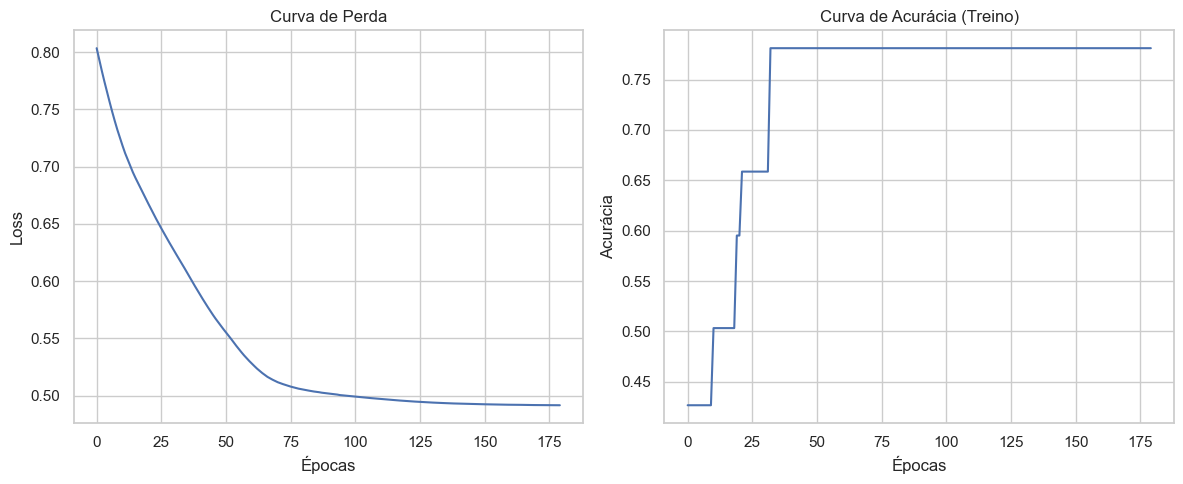

In [314]:

# Inicializar o modelo
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=1,           # Treinaremos uma época por vez
    warm_start=True,      # Permite continuar o treinamento
    random_state=42,
    early_stopping=False
)

# Listas para armazenar histórico
loss_curve = []
accuracy_curve = []
epochs = 180  # Número total de épocas

# Treinamento manual
for epoch in range(epochs):
    mlp.fit(X_train_scaled, y_train)
    
    # Registrar perda
    loss_curve.append(mlp.loss_)
    
    # Calcular e registrar acurácia
    y_pred = mlp.predict(X_train_scaled)
    acc = accuracy_score(y_train, y_pred)
    accuracy_curve.append(acc)
    
    if epoch % 10 == 0:
        print(f"Época {epoch}: Loss = {mlp.loss_:.4f}, Acurácia = {acc:.4f}")

# Plotar as curvas
plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(loss_curve)
plt.title("Curva de Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(accuracy_curve)
plt.title("Curva de Acurácia (Treino)")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.grid(True)

plt.tight_layout()
plt.show()

In [315]:
# Avaliação

y_pred = mlp.predict(X_test_scaled)  

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}") 
print("\nRelatório de Classificação:") 
print(classification_report(y_test, y_pred))  

Acurácia: 0.8000

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.93      0.83        59
           1       0.90      0.66      0.76        56

    accuracy                           0.80       115
   macro avg       0.82      0.80      0.79       115
weighted avg       0.82      0.80      0.80       115



###Métricas do Modelo
Após treinar o modelo, é importante verificar se ele está realmente fazendo boas previsões. Para isso, usamos mais do que apenas a acurácia.

Accuracy (Acurácia): mede a proporção de previsões corretas em relação ao total. Embora útil, pode ser enganosa se uma classe tiver muito mais exemplos que a outra.

Precision (Precisão): indica, entre os casos que o modelo previu como positivos (por exemplo, "sobreviveu"), quantos realmente eram positivos. Alta precisão significa poucos falsos positivos.Precision= VP/VP+FP

Recall (Revocação ou Sensibilidade): mede, entre os casos que realmente eram positivos, quantos o modelo conseguiu identificar corretamente. Alta revocação significa poucos falsos negativos. Recall = VP/VP+FN

F1-Score: é a média harmônica entre precisão e recall. É útil para equilibrar os dois, principalmente quando é importante tanto identificar os positivos quanto evitar falsos alarmes.
F1-Score = 2*(Precision*Recall / Precision+Recall)
Support (Suporte): representa a quantidade real de exemplos de cada classe no conjunto de testes, ajudando a interpretar as métricas anteriores.

Essas métricas juntas fornecem uma visão mais completa da qualidade do modelo, permitindo entender não apenas quantas previsões foram corretas, mas como elas foram corretas (ou erradas).

C:\Users\jmarq\AppData\Local\Temp\ipykernel_12016\373143605.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')


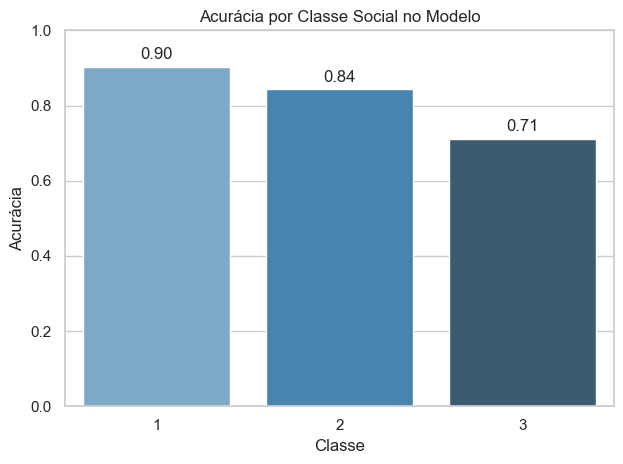

In [316]:
# Avaliação de justiça
def avaliar_justica(model, X_test, y_test, original_df, X_test_scaled):
    X_test_df = X_test.copy()
    X_test_df['Survived_Real'] = y_test.values
    X_test_df['Survived_Pred'] = model.predict(X_test_scaled)
    X_test_df['Pclass'] = original_df.loc[X_test.index, 'Pclass'].values

    resultados = []
    for p in sorted(X_test_df['Pclass'].unique()):
        subset = X_test_df[X_test_df['Pclass'] == p]
        acc = accuracy_score(subset['Survived_Real'], subset['Survived_Pred'])
        resultados.append({'Classe': p, 'Acurácia': acc, 'Total': len(subset)})

    df_result = pd.DataFrame(resultados)
    sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')
    plt.ylim(0, 1)
    plt.title("Acurácia por Classe Social no Modelo")
    for index, row in df_result.iterrows():
        plt.text(index, row.Acurácia + 0.02, f"{row.Acurácia:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

avaliar_justica(mlp, X_test, y_test, df_balanced, X_test_scaled)

In [317]:
# Carregar e preparar o dataset com features extras
df_full = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# Seleção inicial das colunas
df_full = df_full[['Name', 'Sex', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked', 'Survived']]

# Converter sexo para formato numérico
df_full['Sex'] = df_full['Sex'].map({'male': 0, 'female': 1})

# Extrair o título do nome
df_full['Title'] = df_full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
common_titles = ['Mr', 'Mrs', 'Miss', 'Master']
df_full['Title'] = df_full['Title'].apply(lambda t: t if t in common_titles else 'Other')

# Preencher idade com média por título
mean_age_by_title = df_full.groupby('Title')['Age'].mean()
df_full['Age'] = df_full.apply(
    lambda row: mean_age_by_title[row['Title']] if pd.isnull(row['Age']) else row['Age'],
    axis=1
)

# Remover os poucos casos restantes com NaN (ex: Embarked)
df_full = df_full.dropna()

# One-hot encoding para variáveis categóricas
df_full = pd.get_dummies(df_full, columns=['Embarked', 'Title'], drop_first=True)

# Visualizar as primeiras linhas para checagem
print(df_full.head())


<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
C:\Users\jmarq\AppData\Local\Temp\ipykernel_12016\913149916.py:11: SyntaxWarning: invalid escape sequence '\.'
  df_full['Title'] = df_full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


                                                Name  Sex  Pclass   Age  \
0                            Braund, Mr. Owen Harris    0       3  22.0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1       1  38.0   
2                             Heikkinen, Miss. Laina    1       3  26.0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1       1  35.0   
4                           Allen, Mr. William Henry    0       3  35.0   

      Fare  SibSp  Parch  Survived  Embarked_Q  Embarked_S  Title_Miss  \
0   7.2500      1      0         0       False        True       False   
1  71.2833      1      0         1       False       False       False   
2   7.9250      0      0         1       False        True        True   
3  53.1000      1      0         1       False        True       False   
4   8.0500      0      0         0       False        True       False   

   Title_Mr  Title_Mrs  Title_Other  
0      True      False        False  
1     False       True      

C:\Users\jmarq\AppData\Local\Temp\ipykernel_12016\3524835399.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df_mod, palette='Set2')


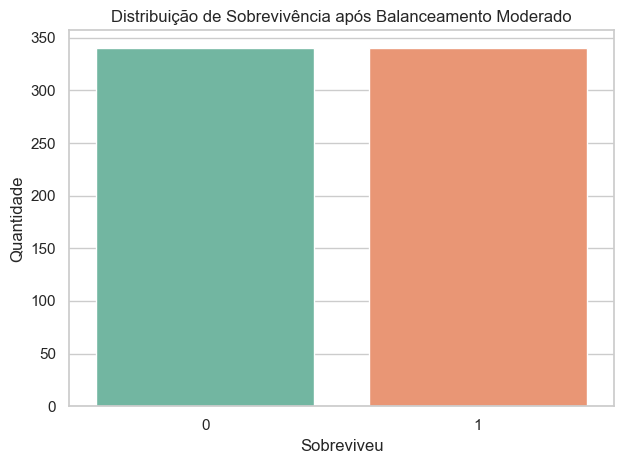

In [318]:
# Balanceamento moderado para mitigar viés ---
survived = df_full[df_full['Survived'] == 1]
not_survived = df_full[df_full['Survived'] == 0]
min_len = min(len(survived), len(not_survived))

df_mod = pd.concat([
    resample(survived, n_samples=min_len, random_state=42),
    resample(not_survived, n_samples=min_len, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# Gráfico de verificação pós-balanceamento
sns.countplot(x='Survived', data=df_mod, palette='Set2')
plt.title("Distribuição de Sobrevivência após Balanceamento Moderado")
plt.xlabel("Sobreviveu")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()


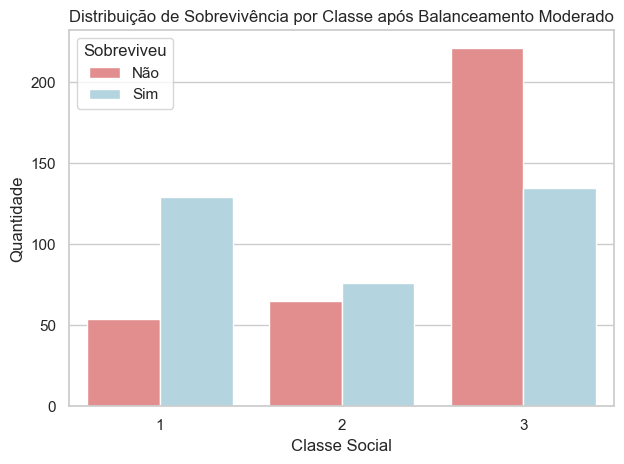

In [319]:
# Gráfico por classe social e sobrevivência
sns.countplot(x='Pclass', hue='Survived', data=df_mod, palette=['lightcoral', 'lightblue'])
plt.title("Distribuição de Sobrevivência por Classe após Balanceamento Moderado")
plt.xlabel("Classe Social")
plt.ylabel("Quantidade")
plt.legend(title='Sobreviveu', labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()


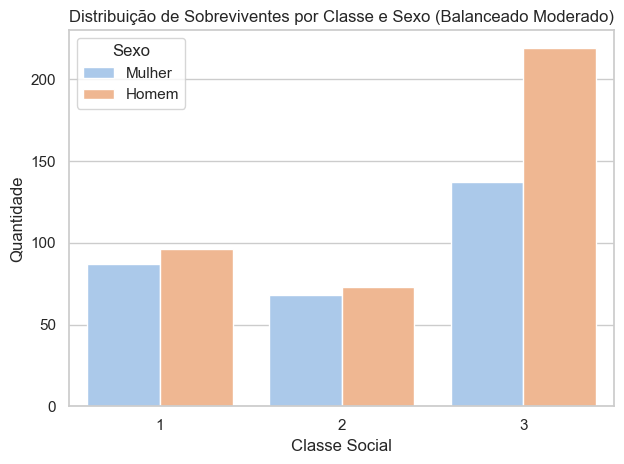

In [320]:
# Mapeia sexo novamente para string (para fins de visualização)
df_mod['Sexo_str'] = df_mod['Sex'].map({0: 'Homem', 1: 'Mulher'})

# Gráfico por classe e sexo
sns.countplot(x='Pclass', hue='Sexo_str', data=df_mod, palette='pastel')
plt.title("Distribuição de Sobreviventes por Classe e Sexo (Balanceado Moderado)")
plt.xlabel("Classe Social")
plt.ylabel("Quantidade")
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

In [321]:
# Separação das features e normalização ---
X = df_mod.drop(columns=['Name', 'Survived', 'Sexo_str'])  # Remove colunas não numéricas
y = df_mod['Survived']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização das features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Shape treino: {X_train_scaled.shape}, Shape teste: {X_test_scaled.shape}")

Shape treino: (544, 12), Shape teste: (136, 12)


Época 0: Loss = 0.7097, Acurácia = 0.4982
Época 10: Loss = 0.6453, Acurácia = 0.5092
Época 20: Loss = 0.5888, Acurácia = 0.7279
Época 30: Loss = 0.5373, Acurácia = 0.7868
Época 40: Loss = 0.4905, Acurácia = 0.8382
Época 50: Loss = 0.4522, Acurácia = 0.8382
Época 60: Loss = 0.4216, Acurácia = 0.8493
Época 70: Loss = 0.4002, Acurácia = 0.8493
Época 80: Loss = 0.3881, Acurácia = 0.8493
Época 90: Loss = 0.3814, Acurácia = 0.8529
Época 100: Loss = 0.3762, Acurácia = 0.8493
Época 110: Loss = 0.3719, Acurácia = 0.8474
Época 120: Loss = 0.3682, Acurácia = 0.8493
Época 130: Loss = 0.3649, Acurácia = 0.8493
Época 140: Loss = 0.3617, Acurácia = 0.8493
Época 150: Loss = 0.3587, Acurácia = 0.8493
Época 160: Loss = 0.3558, Acurácia = 0.8493
Época 170: Loss = 0.3534, Acurácia = 0.8548
Época 180: Loss = 0.3510, Acurácia = 0.8585
Época 190: Loss = 0.3487, Acurácia = 0.8603
Época 200: Loss = 0.3463, Acurácia = 0.8603
Época 210: Loss = 0.3443, Acurácia = 0.8621
Época 220: Loss = 0.3425, Acurácia = 0.8585

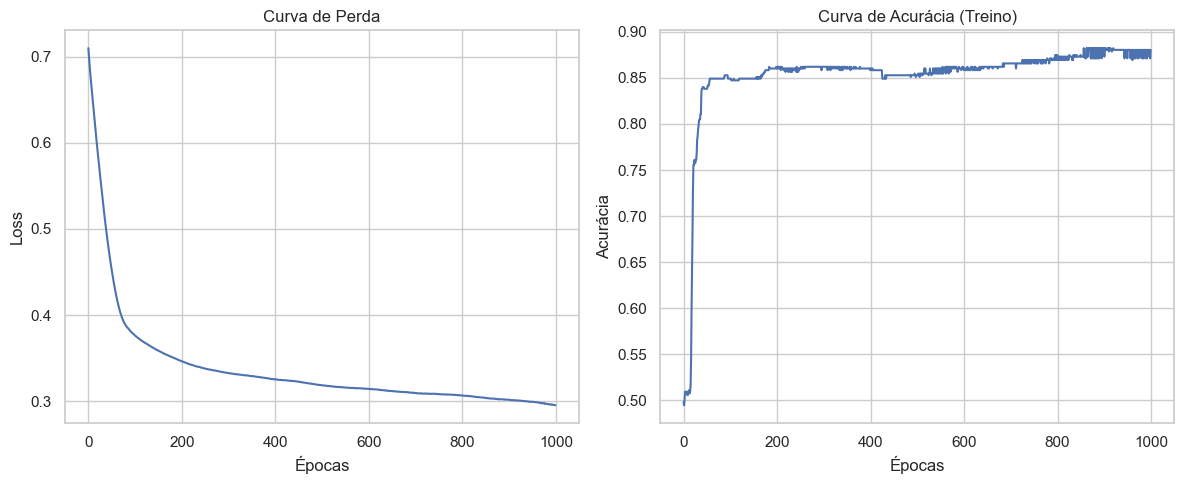

In [322]:

# Inicializar o modelo
mlp_enriched = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=1,           # Treinaremos uma época por vez
    warm_start=True,      # Permite continuar o treinamento
    random_state=42,
    early_stopping=False
)

# Listas para armazenar histórico
loss_curve = []
accuracy_curve = []
epochs = 1000  # Número total de épocas

# Treinamento manual
for epoch in range(epochs):
    mlp_enriched.fit(X_train_scaled, y_train)
    
    # Registrar perda
    loss_curve.append(mlp_enriched.loss_)
    
    # Calcular e registrar acurácia
    y_pred = mlp_enriched.predict(X_train_scaled)
    acc = accuracy_score(y_train, y_pred)
    accuracy_curve.append(acc)
    
    if epoch % 10 == 0:
        print(f"Época {epoch}: Loss = {mlp_enriched.loss_:.4f}, Acurácia = {acc:.4f}")

# Plotar as curvas
plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(loss_curve)
plt.title("Curva de Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(accuracy_curve)
plt.title("Curva de Acurácia (Treino)")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.grid(True)

plt.tight_layout()
plt.show()


 Modelo Enriquecido com Features Adicionais
Acurácia: 0.8676
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        60
           1       0.95      0.80      0.87        76

    accuracy                           0.87       136
   macro avg       0.87      0.88      0.87       136
weighted avg       0.88      0.87      0.87       136



C:\Users\jmarq\AppData\Local\Temp\ipykernel_12016\373143605.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')


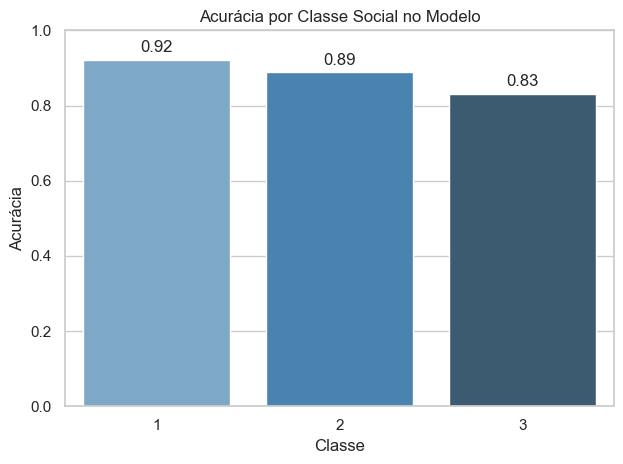

In [323]:
# Predição com o modelo mlp_enriched
y_pred_enriched = mlp_enriched.predict(X_test_scaled)

print("\n Modelo Enriquecido com Features Adicionais")
print(f"Acurácia: {accuracy_score(y_test, y_pred_enriched):.4f}")
print(classification_report(y_test, y_pred_enriched))

# Avaliação de justiça por classe social para o modelo enriquecido
avaliar_justica(mlp_enriched, X_test, y_test, df_mod, X_test_scaled)


C:\Users\jmarq\AppData\Local\Temp\ipykernel_12016\2221164153.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='Sexo', y='Acurácia', palette='Set2')


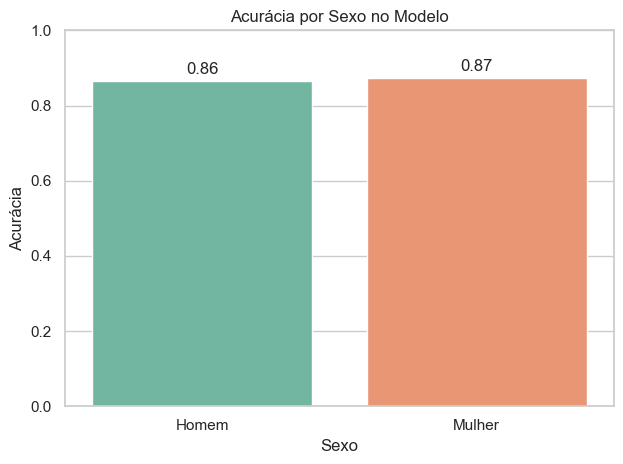

In [324]:
def avaliar_justica_por_sexo(model, X_test, y_test, original_df, X_test_scaled):
    X_test_df = X_test.copy()
    X_test_df['Survived_Real'] = y_test.values
    X_test_df['Survived_Pred'] = model.predict(X_test_scaled)
    X_test_df['Sex'] = original_df.loc[X_test.index, 'Sex'].values
    X_test_df['Sexo'] = X_test_df['Sex'].map({0: 'Homem', 1: 'Mulher'})

    resultados = []
    for s in sorted(X_test_df['Sex'].unique()):
        subset = X_test_df[X_test_df['Sex'] == s]
        acc = accuracy_score(subset['Survived_Real'], subset['Survived_Pred'])
        resultados.append({'Sexo': 'Homem' if s == 0 else 'Mulher', 'Acurácia': acc, 'Total': len(subset)})

    df_result = pd.DataFrame(resultados)

    sns.barplot(data=df_result, x='Sexo', y='Acurácia', palette='Set2')
    plt.ylim(0, 1)
    plt.title("Acurácia por Sexo no Modelo")
    for index, row in df_result.iterrows():
        plt.text(index, row.Acurácia + 0.02, f"{row.Acurácia:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

avaliar_justica_por_sexo(mlp_enriched, X_test, y_test, df_mod, X_test_scaled)


In [325]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Carregar os dados de novos passageiros
df_orig = pd.read_csv('novos_passageiros.csv')

# Selecionar colunas relevantes
novo_df = df_orig[['Name', 'Sex', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked']].copy()

# Imputação para colunas numéricas
imputer_num = SimpleImputer(strategy='median')
novo_df[['Age', 'Fare']] = imputer_num.fit_transform(novo_df[['Age', 'Fare']])

# Imputação para coluna categórica (Embarked)
imputer_cat = SimpleImputer(strategy='most_frequent')
novo_df[['Embarked']] = imputer_cat.fit_transform(novo_df[['Embarked']])

# Codificar sexo
novo_df['Sex'] = novo_df['Sex'].map({'male': 0, 'female': 1})

# Extrair títulos do nome
novo_df['Title'] = df_orig['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
novo_df['Title'] = novo_df['Title'].apply(lambda t: t if t in ['Mr', 'Mrs', 'Miss', 'Master'] else 'Other')

# One-hot encoding das colunas categóricas
novo_df = pd.get_dummies(novo_df, columns=['Embarked', 'Title'], drop_first=True)

# Garantir compatibilidade com X_train
for col in X_train.columns:
    if col not in novo_df.columns:
        novo_df[col] = 0
novo_df = novo_df[X_train.columns]

# Normalização com o scaler treinado
novodf_scaled = scaler.transform(novo_df)



In [326]:
# Fazer predições com o modelo treinado
novas_predicoes = mlp_enriched.predict(novodf_scaled)
probabilidades = mlp_enriched.predict_proba(novodf_scaled)

# Criar uma cópia do DataFrame original para adicionar as predições
df_resultado = df_orig.copy()
df_resultado.loc[novo_df.index, 'Predicted_Survived'] = novas_predicoes
df_resultado.loc[novo_df.index, 'Prob_Survived'] = probabilidades[:, 1]

# Salvar o DataFrame com as predições
df_resultado.to_csv("predicoes_passageiros.csv", index=False)

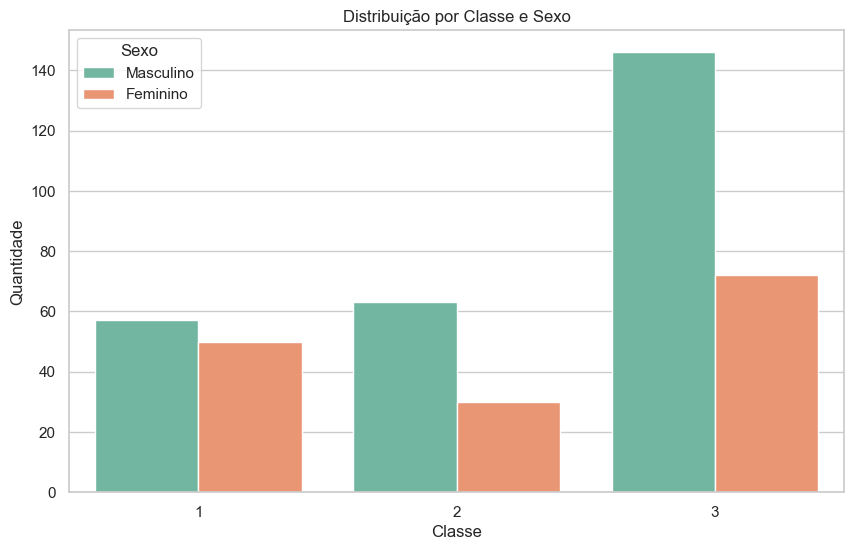

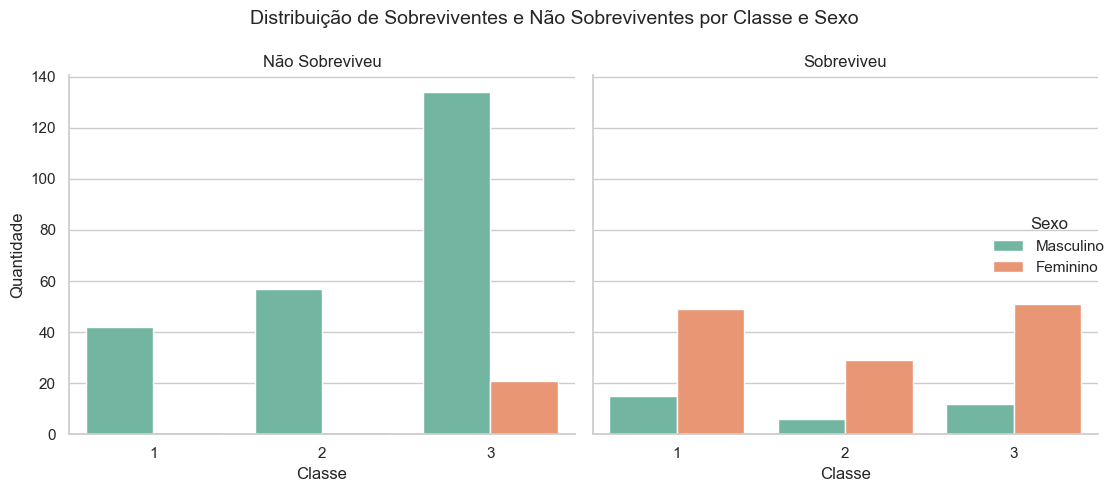

In [327]:
# Copiar e preparar o DataFrame para plotagem
df_plot = df_resultado.copy()

# Mapear valores numéricos para categorias legíveis
df_plot['Predicted_Survived'] = df_plot['Predicted_Survived'].map({0: 'Não Sobreviveu', 1: 'Sobreviveu'})

# Caso 'Sex' ainda esteja numérico, mapear para texto; se já estiver texto, ignora
if df_plot['Sex'].dtype != object:
    df_plot['Sex'] = df_plot['Sex'].map({0: 'Masculino', 1: 'Feminino'})
else:
    df_plot['Sex'] = df_plot['Sex'].map({'male': 'Masculino', 'female': 'Feminino'})

# Filtrar apenas linhas com predições para evitar erro com NaNs
df_plot = df_plot.dropna(subset=['Predicted_Survived'])

# Plot simples com countplot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_plot, 
    x='Pclass', 
    hue='Sex', 
    palette='Set2',
    hue_order=['Masculino', 'Feminino'],
    dodge=True,
    order=sorted(df_plot['Pclass'].unique()),
)
plt.title('Distribuição por Classe e Sexo')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.legend(title='Sexo')
plt.show()

# Plot com separação por sobrevivência prevista
g = sns.catplot(
    data=df_plot, 
    kind='count',
    x='Pclass', 
    hue='Sex', 
    col='Predicted_Survived',
    palette='Set2', 
    height=5, 
    aspect=1
)

g.set_axis_labels("Classe", "Quantidade")
g.set_titles("{col_name}")
g._legend.set_title("Sexo")
g.fig.suptitle("Distribuição de Sobreviventes e Não Sobreviventes por Classe e Sexo", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


###Mitigação de Viés via Penalização Direcionada de Pesos
Nesta etapa, foi aplicada uma técnica de mitigação de viés baseada na penalização direta dos pesos da rede neural associados a variáveis sensíveis.

O foco foi reduzir a dependência do modelo em relação às variáveis Fare e Pclass, que são as features que criam uma injustiça pos são relacionadas dieramente a condição socioeconômica dos passageiros do Titanic. Essas variáveis estão fortemente correlacionadas com as chances de sobrevivência, devido a desigualdades históricas.

Se o modelo aprender padrões baseados exclusivamente nessas variáveis, ele tende a reproduzir um comportamento enviesado, favorecendo certos grupos sociais de forma desproporcional.

####Como foi implementado?
Foi adicionada uma penalização diretamente sobre os pesos da primeira camada da rede neural ligados às variáveis Fare e Pclass.

Essa penalização segue a fórmula:
Penalização=λ x (∑(pesos da Fare)^2 + ∑(pesos da Pclass)^2)
 
λ (lambda): Fator de penalização (hiperparâmetro)

Pesos penalizados: Somente os pesos conectados às features Fare e Pclass na primeira camada

####Por que essa abordagem funciona?
O treinamento da rede com essa penalização gera um gradiente adicional que "puxa" os pesos dessas variáveis para perto de zero. Isso obriga o modelo a:

Usar menos informações relacionadas à condição social do passageiro

Buscar padrões mais justos e equilibrados em outras variáveis 

In [328]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

# Fixar seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dados para Tensor
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Definindo o modelo
class MLP_Penalizado(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Penalizado, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = MLP_Penalizado(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Índices das features a penalizar
fare_idx = list(X_train.columns).index('Fare')
pclass_idx = list(X_train.columns).index('Pclass')

# Treinamento com penalização combinada
epochs = 1000
penalty_lambda = 0.1

loss_history = []
acc_history = []
fare_weight_history = []
pclass_weight_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    
    # Pesos das features específicas
    fare_weights = model.fc1.weight[:, fare_idx]
    pclass_weights = model.fc1.weight[:, pclass_idx]
    
    # Penalização combinada
    penalty = penalty_lambda * (torch.sum(fare_weights ** 2) + torch.sum(pclass_weights ** 2))
    
    total_loss = loss + penalty
    total_loss.backward()
    optimizer.step()
    
    # Acurácia no treino
    preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
    acc = accuracy_score(y_train, preds)
    
    loss_history.append(total_loss.item())
    acc_history.append(acc)
    
    # Salvar evolução dos pesos
    fare_weight_history.append(fare_weights.detach().cpu().norm().item())
    pclass_weight_history.append(pclass_weights.detach().cpu().norm().item())
    
    if epoch % 100 == 0:
        print(f"Época {epoch}: Loss Total={total_loss.item():.4f}, Acurácia={acc:.4f}")


# Avaliação no Teste

model.eval()
with torch.no_grad():
    outputs_test = model(X_test_torch)
    preds_test = (outputs_test.cpu().numpy() > 0.5).astype(int)
    acc_test = accuracy_score(y_test, preds_test)

print(f"\nAcurácia no Teste: {acc_test:.4f}")
print(classification_report(y_test, preds_test))


Época 0: Loss Total=0.7887, Acurácia=0.4853
Época 100: Loss Total=0.5511, Acurácia=0.8327
Época 200: Loss Total=0.4147, Acurácia=0.8511
Época 300: Loss Total=0.3936, Acurácia=0.8529
Época 400: Loss Total=0.3791, Acurácia=0.8566
Época 500: Loss Total=0.3672, Acurácia=0.8566
Época 600: Loss Total=0.3564, Acurácia=0.8585
Época 700: Loss Total=0.3464, Acurácia=0.8603
Época 800: Loss Total=0.3376, Acurácia=0.8621
Época 900: Loss Total=0.3283, Acurácia=0.8640

Acurácia no Teste: 0.8676
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        60
           1       0.94      0.82      0.87        76

    accuracy                           0.87       136
   macro avg       0.87      0.87      0.87       136
weighted avg       0.88      0.87      0.87       136



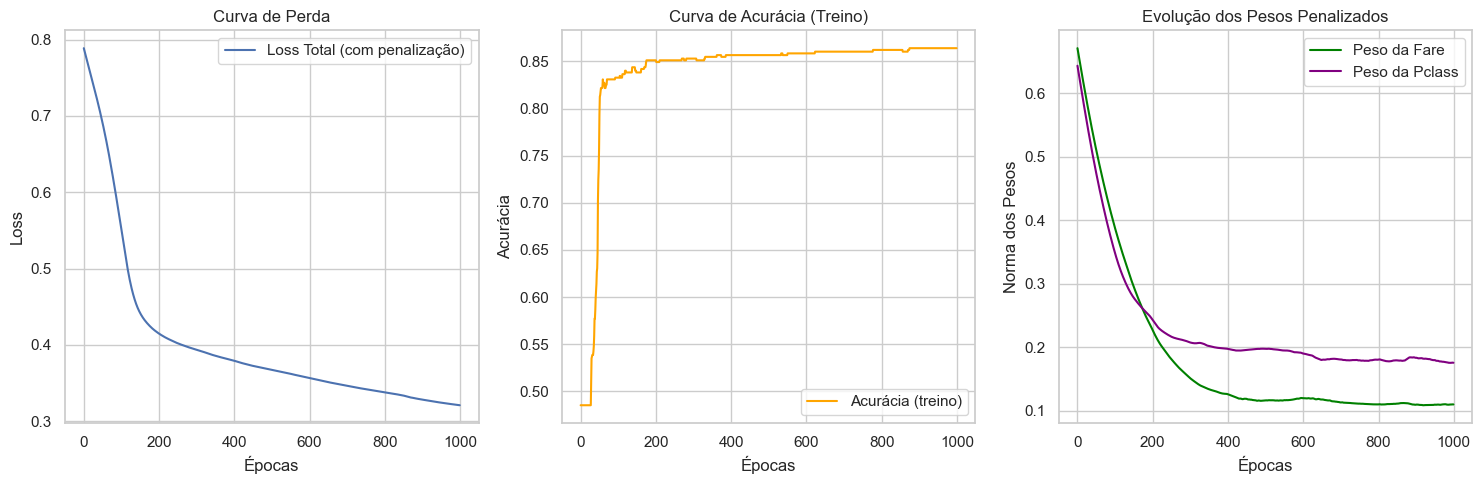

In [329]:

# plots: Perda e Acurácia

plt.figure(figsize=(15,5))

# Perda
plt.subplot(1,3,1)
plt.plot(loss_history, label='Loss Total (com penalização)')
plt.title("Curva de Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Acurácia
plt.subplot(1,3,2)
plt.plot(acc_history, label='Acurácia (treino)', color='orange')
plt.title("Curva de Acurácia (Treino)")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)

# Evolução dos Pesos
plt.subplot(1,3,3)
plt.plot(fare_weight_history, label='Peso da Fare', color='green')
plt.plot(pclass_weight_history, label='Peso da Pclass', color='purple')
plt.title("Evolução dos Pesos Penalizados")
plt.xlabel("Épocas")
plt.ylabel("Norma dos Pesos")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


###Interpretação do comportamento observado:
No início (época 0):

Os pesos da Fare e da Pclass começam com valores mais altos (Isso é esperado, pois a inicialização é aleatória).

Durante o treinamento:

A penalização força os pesos da Fare e da Pclass a diminuírem gradativamente.

O modelo é "empurrado" para depender menos dessas variáveis.

Os pesos chegam a um ponto de estabilização, onde continuam sendo pequenos, mas não zeram totalmente.

Isso acontece porque a penalização está equilibrando com dois objetivos:
Minimizar o erro de predição (nção de Perda de Entropia Cruzada Binária - BCELoss)
Reduzir os pesos de Fare e Pclass

C:\Users\jmarq\AppData\Local\Temp\ipykernel_12016\3171931580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')


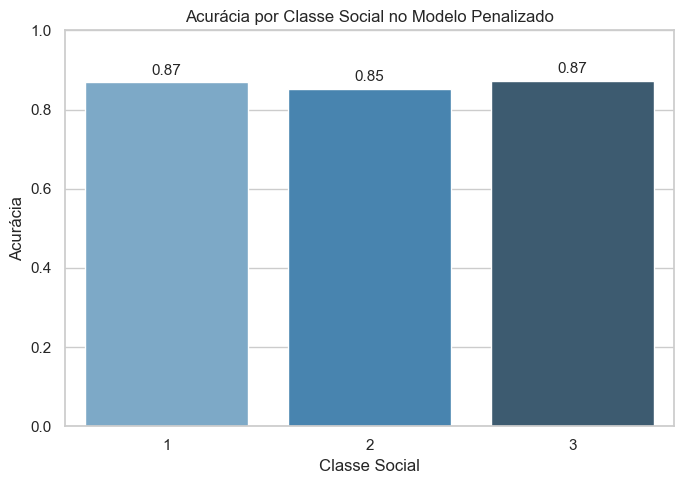

In [330]:
def avaliar_justica_torch(preds_test, y_test, X_test, original_df):
    X_test_df = X_test.copy()
    X_test_df['Survived_Real'] = y_test.values
    X_test_df['Survived_Pred'] = preds_test
    X_test_df['Pclass'] = original_df.loc[X_test.index, 'Pclass'].values

    resultados = []
    for p in sorted(X_test_df['Pclass'].unique()):
        subset = X_test_df[X_test_df['Pclass'] == p]
        acc = accuracy_score(subset['Survived_Real'], subset['Survived_Pred'])
        resultados.append({'Classe': p, 'Acurácia': acc, 'Total': len(subset)})

    df_result = pd.DataFrame(resultados)

    plt.figure(figsize=(7,5))
    ax = sns.barplot(data=df_result, x='Classe', y='Acurácia', palette='Blues_d')
    plt.ylim(0, 1)
    plt.title("Acurácia por Classe Social no Modelo Penalizado")
    plt.xlabel("Classe Social")
    plt.ylabel("Acurácia")

    for index, row in df_result.iterrows():
        plt.text(index, row.Acurácia + 0.02, f"{row.Acurácia:.2f}", 
                 ha='center', fontsize=11)
    
    plt.tight_layout()
    plt.show()
avaliar_justica_torch(preds_test, y_test, X_test, df_mod)
